In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('seaducks'), '..')))
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('seaducks'), '..')))
import pandas as pd

from seaducks.models.linear_regression_model import LinearRegressionModel as LR
from seaducks import assign_each_position_a_bin
import matplotlib.pyplot as plt
# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.style.use('ggplot')

In [2]:
# load data
drifter_dataset = pd.read_hdf('../data/filtered_nao_drifters_with_sst_gradient.h5')
drifter_dataset['day_of_year'] = drifter_dataset['time'].apply(lambda t : t.timetuple().tm_yday)

Helper functions:

In [8]:
from shapely.geometry import Polygon
import numpy as np
from numpy import linalg
def cuts2poly(tuple_tuple) -> Polygon:
    """

    Args:
        tuple_tuple: a tuple of pd cuts, designed for .groupby([lon_cut, lat_cut]) operations
    Returns:
         a Shapely Polygon containing the square resulting from the cuts.
    """
    lon, lat = tuple_tuple
    lon1, lon2 = lon.left, lon.right
    lat1, lat2 = lat.left, lat.right
    return Polygon(np.array([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid1 import make_axes_locatable

extent = [-85.01,#summaries['lon'].min(),
          drifter_dataset['lon'].max(),
          -0.01,
          drifter_dataset['lat'].max()
         ]
def add_gridlines(ax, xlocs = [-85, -70, -55, -40],
                      ylocs = list(range(0,66,15))):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray',
                      alpha=0.5, linestyle='--', 
                      
                     )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines=False
    gl.xlocator = mticker.FixedLocator(xlocs)
    gl.ylocator = mticker.FixedLocator(ylocs)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
def plot_column(daf, column, ax, cmap='seismic', vmin_manual=None, vmax_manual=None):
    vmin, vmax =daf[column].min(), daf[column].max()
    changed_vmin, changed_vmax = False, False
    if vmin_manual is not None:
        changed_vmin = vmin!=vmin_manual
        vmin = vmin_manual
    if vmax_manual is not None:
        changed_vmax = vmax!=vmax_manual
        vmax = vmax_manual
        #norm = mpl.colors.LogNorm(vmin=daf[column].min(), vmax=daf[column].max())
    extend="neither"
    if changed_vmin:
        if changed_vmax:
            extend="both"
        else:
            extend="min"
    else:
        if changed_vmax:
            extend="max"
        
    
    if cmap == 'seismic':
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    f = ax.get_figure()
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                   extend=extend)
    f.add_axes(cax)
    crs = ccrs.PlateCarree()
    for color, rows in daf.groupby(column):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(
            rows["geometry"], crs=crs, facecolor=color_mapped, edgecolor=color_mapped
        )
    return cax

def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.26, 0.5, '', transform=ax.transAxes, 
            size=13, weight='bold')


In [18]:
def rmse(vec1,vec2):
    return np.sqrt(np.mean(np.square(vec1-vec2)))

Create drifter models

In [4]:
# create bathtub model
drifter_dataset.loc[:,'base_prediction_u'] = 0
drifter_dataset.loc[:,'base_prediction_v'] = 0

In [5]:
# create a linear model
covs = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
covs_no_sst = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty']
lr_model = LR(drifter_dataset,covs)
lr_model_no_sst = LR(drifter_dataset,covs_no_sst)

In [6]:
# calclate parameter estimate
lr_model.calculate_param_estimate()
lr_model_no_sst.calculate_param_estimate()

In [7]:
# perform linear regression for each drifter in the dataset

drifter_dataset.loc[:,'lr_prediction'] = drifter_dataset.apply(lambda row : lr_model.lr(row[covs],lr_model.param_estimate),axis=1)
# perform linear regression for each drifter in the dataset

drifter_dataset.loc[:,'lr_prediction_no_sst'] = drifter_dataset.apply(lambda row : lr_model_no_sst.lr(row[covs_no_sst],lr_model_no_sst.param_estimate),axis=1)

Measuring Errors

In [9]:
# calculate MAAO for each prediction
drifter_dataset.loc[:,'maao'] = drifter_dataset.apply(lambda row: np.rad2deg(np.arccos(np.dot(row['lr_prediction'],np.array(row[['u','v']]))/(linalg.norm(row['lr_prediction'])*linalg.norm(np.array(row[['u','v']]))))),axis=1)
drifter_dataset.loc[:,'maao_no_sst'] = drifter_dataset.apply(lambda row: np.rad2deg(np.arccos(np.dot(row['lr_prediction_no_sst'],np.array(row[['u','v']]))/(linalg.norm(row['lr_prediction_no_sst'])*linalg.norm(np.array(row[['u','v']]))))),axis=1)

In [16]:
def err_df(drifter_dataset,lat_grid,lon_grid,bin_size):
    '''
    Creates a dataframe with the same indices as drifter_dataset 
    '''

    # bin the domain 
    df = assign_each_position_a_bin(drifter_dataset,lat_grid, lon_grid, bin_size=bin_size)
    vars = df.columns

    # initialise 
    ## set indices
    idx = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x:x).index
    idx = np.array([ii for ii in idx])
    idx0 = [ii[0] for ii in idx]
    idx1 = [ii[1] for ii in idx]

    plot_frame = pd.DataFrame(index=[idx0,idx1])
    
    # with sst
    plot_frame.loc[:,'rmse'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']]) - np.array([val for val in row['lr_prediction']])))))
    plot_frame.loc[:,'maao'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x :np.mean(x['maao']))  

    #without sst
    plot_frame.loc[:,'rmse_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']]) - np.array([val for val in row['lr_prediction_no_sst']])))))
    plot_frame.loc[:,'maao_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x :np.mean(x['maao_no_sst']))  

    #baseline
    plot_frame.loc[:,'rmse_baseline'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']])-np.array(row[['base_prediction_u','base_prediction_v']])))))

    # percentage decreases

    plot_frame['percentage_decrease_rmse'] = plot_frame.apply(lambda row: 100*(row['rmse']-row['rmse_no_sst'])/row['rmse_no_sst'],axis=1)
    plot_frame['percentage_decrease_maao'] = plot_frame.apply(lambda row: 100*(row['maao']-row['maao_no_sst'])/row['maao_no_sst'],axis=1)
    plot_frame['percentage_decrease_baseline_rmse'] = plot_frame.apply(lambda row: 100*(row['rmse']-row['rmse_baseline'])/row['rmse_baseline'],axis=1)

    plot_frame.dropna(inplace=True)
    gpd = list(map(cuts2poly,plot_frame.index))
    plot_frame['geometry']=gpd

    # add average longitudes and latitudes
    lons = np.array([(idx[0].left +idx[0].right)/2 for idx in plot_frame.index])
    lats = np.array([(idx[1].left +idx[1].right)/2 for idx in plot_frame.index])
    plot_frame['longitude'] = lons
    plot_frame['latitude'] = lats

    return plot_frame

In [17]:
# create error dataset

bin_size = 0.2
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)

errs = err_df(drifter_dataset,lat_grid,lon_grid,bin_size)

C:\Users\vm2218\AppData\Local\Temp\ipykernel_14508\414892776.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,'rmse'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']]) - np.array([val for val in row['lr_prediction']])))))
C:\Users\vm2218\AppData\Local\Temp\ipykernel_14508\414892776.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,'maao'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x :np.mean(x['maao']))
C:\Users\vm2218\AppData\Local\Temp\ipykernel_14508\414892776.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,'rmse_no_sst'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda r

In [24]:
gulf_stream_drifter_dataset = drifter_dataset.query('-75 < lon < -55 and 35 <lat <40')
errs_gulf_stream = errs.query('-75 < longitude < -55 and 35 <latitude <40')

Results: Values and Figures

In [41]:
# overall RMSEs
na_rmse_with_sst = 100*rmse(np.array(drifter_dataset[['u','v']]),np.array([val for val in drifter_dataset['lr_prediction']]))
na_rmse_no_sst = 100*rmse(np.array(drifter_dataset[['u','v']]),np.array([val for val in drifter_dataset['lr_prediction_no_sst']]))
base_na_rmse = 100*rmse(np.array(drifter_dataset[['u','v']]),np.array(drifter_dataset[['base_prediction_u','base_prediction_v']]))

gulf_stream_rmse_with_sst = 100*rmse(np.array(gulf_stream_drifter_dataset[['u','v']]),np.array([val for val in gulf_stream_drifter_dataset['lr_prediction']]))
gulf_stream_rmse_no_sst = 100*rmse(np.array(gulf_stream_drifter_dataset[['u','v']]),np.array([val for val in gulf_stream_drifter_dataset['lr_prediction_no_sst']]))
base_gulf_stream_rmse = 100*rmse(np.array(gulf_stream_drifter_dataset[['u','v']]),np.array(gulf_stream_drifter_dataset[['base_prediction_u','base_prediction_v']]))
# std of RMSE across bins

na_rmse_std_with_sst = np.std(errs['rmse'])
na_rmse_std_no_sst = np.std(errs['rmse_no_sst'])
na_rmse_std_baseline = np.std(errs['rmse_baseline'])

gulf_stream_rmse_std_with_sst = np.std(errs_gulf_stream['rmse'])
gulf_stream_rmse_std_no_sst = np.std(errs_gulf_stream['rmse_no_sst'])
gulf_stream_rmse_std_baseline = np.std(errs_gulf_stream['rmse_baseline'])

# MAAO

na_maao_with_sst = np.mean(errs['maao'])
na_maao_no_sst = np.mean(errs['maao_no_sst'])

gulf_stream_maao_with_sst = np.mean(errs_gulf_stream['maao'])
gulf_stream_maao_no_sst = np.mean(errs_gulf_stream['maao_no_sst'])

# std of MAAO across bins
na_maao_std_with_sst = np.std(errs['maao'])
na_maao_std_no_sst = np.std(errs['maao_no_sst'])

gulf_stream_maao_std_with_sst = np.std(errs_gulf_stream['maao'])
gulf_stream_maao_std_no_sst = np.std(errs_gulf_stream['maao_no_sst'])

# percentage decrease in errors (minus sign for percentage decrease)
## North Atlantic
per_dec_na_rmse_no_sst = -100*(na_rmse_with_sst-na_rmse_no_sst)/na_rmse_no_sst
per_dec_na_rmse_baseline = -100*(na_rmse_with_sst-base_na_rmse)/base_na_rmse
per_dec_na_maao_no_sst = -100*(na_maao_with_sst - na_maao_no_sst)/na_maao_no_sst
## Gulf Stream
per_dec_gs_rmse_no_sst = -100*(gulf_stream_rmse_with_sst-gulf_stream_rmse_no_sst)/gulf_stream_rmse_no_sst
per_dec_gs_rmse_baseline = -100*(gulf_stream_rmse_with_sst - base_gulf_stream_rmse)/base_gulf_stream_rmse
per_dec_gs_maao_no_sst = -100*(gulf_stream_maao_with_sst - gulf_stream_maao_no_sst)/gulf_stream_maao_no_sst

# std of percentage error decrease
## North Atlantic
per_dec_na_rmse_no_sst_std = np.std(errs['percentage_decrease_rmse'])
per_dec_na_rmse_baseline_std = np.std(errs['percentage_decrease_baseline_rmse'])
per_dec_na_maao_no_sst_std = np.std(errs['percentage_decrease_maao'])
## Gulf Stream
per_dec_gs_rmse_no_sst_std = np.std(errs_gulf_stream['percentage_decrease_rmse'])
per_dec_gs_rmse_baseline_std = np.std(errs_gulf_stream['percentage_decrease_baseline_rmse'])
per_dec_gs_maao_no_sst_std = np.std(errs_gulf_stream['percentage_decrease_maao'])

In [31]:
print(f'Northwest Atlantic Ocean RMSE')
print(f'RMSE (with sst): {round(na_rmse_with_sst,2)}')
print(f'    with standard deviation: {round(na_rmse_std_with_sst,2)}')
print(f'RMSE (without sst): {round(na_rmse_no_sst,2)}')
print(f'    with standard deviation: {round(na_rmse_std_no_sst,2)}')
print(f'RMSE (baseline): {round(base_na_rmse,2)}')
print(f'    with standard deviation: {round(na_rmse_std_baseline,2)}')

Northwest Atlantic Ocean RMSE
RMSE (with sst): 21.21
    with standard deviation: 11.98
RMSE (without sst): 21.64
    with standard deviation: 12.44
RMSE (baseline): 24.76
    with standard deviation: 13.88


In [35]:
print(f'Gulf Stream RMSE')
print(f'RMSE (with sst): {round(gulf_stream_rmse_with_sst,2)}')
print(f'    with standard deviation: {round(gulf_stream_rmse_std_with_sst,2)}')
print(f'RMSE (without sst): {round(gulf_stream_rmse_no_sst,2)}')
print(f'    with standard deviation: {round(gulf_stream_rmse_std_no_sst,2)}')
print(f'RMSE (baseline): {round(base_gulf_stream_rmse,2)}')
print(f'    with standard deviation: {round(gulf_stream_rmse_std_baseline,2)}')

Gulf Stream RMSE
RMSE (with sst): 35.02
    with standard deviation: 14.22
RMSE (without sst): 36.13
    with standard deviation: 15.34
RMSE (baseline): 41.67
    with standard deviation: 16.99


In [36]:
print(f'Northwest Atlantic Ocean MAAO')
print(f'MAAO (with sst): {round(na_maao_with_sst,2)}')
print(f'    with standard deviation: {round(na_maao_std_with_sst,2)}')
print(f'MAAO (without sst): {round(na_maao_no_sst,2)}')
print(f'    with standard deviation: {round(na_maao_std_no_sst,2)}')

Northwest Atlantic Ocean MAAO
MAAO (with sst): 60.1
    with standard deviation: 19.15
MAAO (without sst): 61.88
    with standard deviation: 18.66


In [39]:
print(f'Gulf Stream MAAO')
print(f'MAAO (with sst): {round(gulf_stream_maao_with_sst,2)}')
print(f'    with standard deviation: {round(gulf_stream_maao_std_with_sst,2)}')
print(f'MAAO (without sst): {round(gulf_stream_maao_no_sst,2)}')
print(f'    with standard deviation: {round(gulf_stream_maao_std_no_sst,2)}')

Gulf Stream MAAO
MAAO (with sst): 61.9
    with standard deviation: 17.31
MAAO (without sst): 64.68
    with standard deviation: 15.86


In [42]:
print(f'Northwest Atlantic Ocean Percentage Decrease of Error')
print(f'Model with sst decreased RMSE by: {round(per_dec_na_rmse_no_sst,2)} percent over MODEL WITHOUT SST')
print(f'    with standard deviation: {round(per_dec_na_rmse_no_sst_std,2)}')
print(f'Model with sst decreased RMSE by: {round(per_dec_na_rmse_baseline,2)} percent over BASELINE')
print(f'    with standard deviation: {round(per_dec_na_rmse_baseline_std,2)}')
print(f'Model with sst decreased MAAO by: {round(per_dec_na_maao_no_sst,2)} percent over MODEL WITHOUT SST')
print(f'    with standard deviation: {round(per_dec_na_maao_no_sst_std,2)}')

Northwest Atlantic Ocean Percentage Decrease of Error
Model with sst decreased RMSE by: 1.98 percent over MODEL WITHOUT SST
    with standard deviation: 11.6
Model with sst decreased RMSE by: 14.35 percent over BASELINE
    with standard deviation: 30.74
Model with sst decreased MAAO by: 2.87 percent over MODEL WITHOUT SST
    with standard deviation: 30.97


In [43]:
print(f'Gulf Stream Percentage Decrease of Error')
print(f'Model with sst decreased RMSE by: {round(per_dec_gs_rmse_no_sst,2)} percent over MODEL WITHOUT SST')
print(f'    with standard deviation: {round(per_dec_gs_rmse_no_sst_std,2)}')
print(f'Model with sst decreased RMSE by: {round(per_dec_gs_rmse_baseline,2)} percent over BASELINE')
print(f'    with standard deviation: {round(per_dec_gs_rmse_baseline_std,2)}')
print(f'Model with sst decreased MAAO by: {round(per_dec_gs_maao_no_sst,2)} percent over MODEL WITHOUT SST')
print(f'    with standard deviation: {round(per_dec_gs_maao_no_sst_std,2)}')

Gulf Stream Percentage Decrease of Error
Model with sst decreased RMSE by: 3.09 percent over MODEL WITHOUT SST
    with standard deviation: 10.81
Model with sst decreased RMSE by: 15.97 percent over BASELINE
    with standard deviation: 17.4
Model with sst decreased MAAO by: 4.3 percent over MODEL WITHOUT SST
    with standard deviation: 13.82


fig successful
percentage_decrease_rmse plot successful
percentage_decrease_maao plot successful
letters added


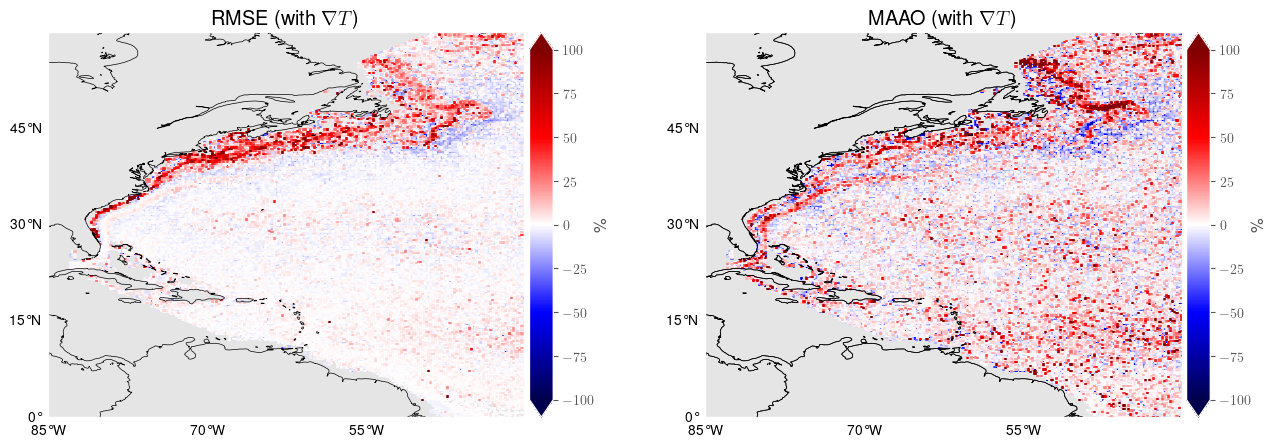

In [101]:
fig, axs = plt.subplots(1,2,figsize=(15,5), subplot_kw= {"projection":ccrs.PlateCarree()})
metric_names = ['percentage_decrease_rmse','percentage_decrease_maao']
cbar_names = [r"\%", r"\%"]
print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[col]
    cax = plot_column(full_df,
                      metric,
                      ax=current_ax,
                      cmap='seismic',
                      vmin_manual=-100,
                      vmax_manual=100)
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#axs[1,1].quiver(spatial_summaries['lon'], spatial_summaries['lat'], spatial_summaries['mean_lon'], spatial_summaries['mean_lat'], zorder=15)
axs[1].coastlines()
axs[1].set_aspect('auto')
#axs[1,1].set_title("Mean Predicted Velocity")
#fig.tight_layout()

plt.show()

In [120]:
np.mean(full_df['maao'])

59.550259420237204

fig successful
rmse plot successful
maao plot successful
letters added


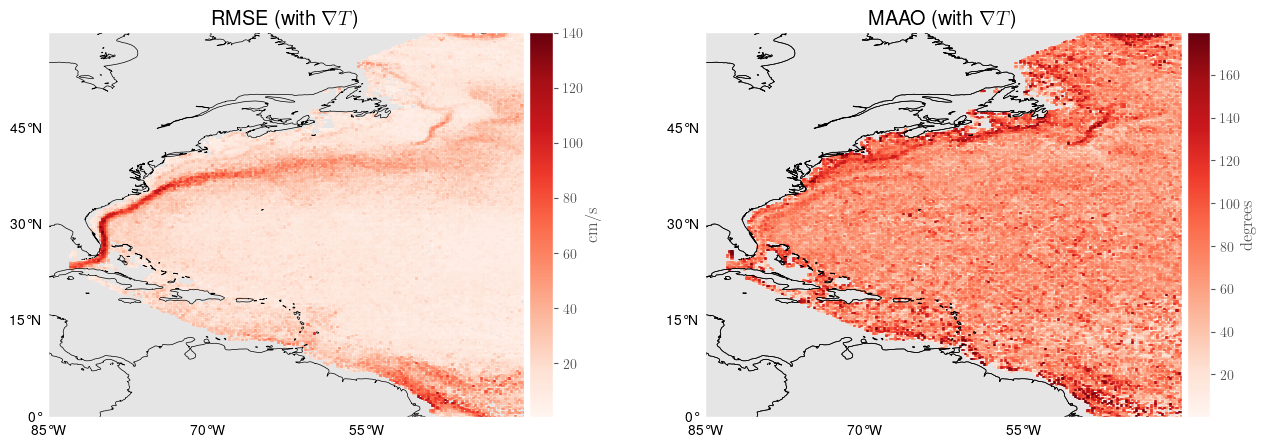

In [81]:
bin_size = 0.5
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)
errs = ['rmse','maao']

#df = err_df(drifter_dataset, lat_grid, lon_grid, bin_size,errs)
metric_names = [err for err in errs]
cbar_names = [r"$\mathrm{cm/s}$", r"$\mathrm{degrees}$"]
titles = [r'RMSE (with $\nabla T$)',
          r'MAAO (with $\nabla T$)'
         ]

fig, axs = plt.subplots(1,2,figsize=(15,5), subplot_kw= {"projection":ccrs.PlateCarree()})
print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[col]
    cax = plot_column(df,
                      metric,
                      ax=current_ax,
                      cmap='Reds')
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#axs[1,1].quiver(spatial_summaries['lon'], spatial_summaries['lat'], spatial_summaries['mean_lon'], spatial_summaries['mean_lat'], zorder=15)
axs[1].coastlines()
axs[1].set_aspect('auto')
#axs[1,1].set_title("Mean Predicted Velocity")
#fig.tight_layout()

plt.show()